Step 1: Connecting to DB and retrieving data...
Number of total pairs: 44118
Step 2: Building character vocabulary...
Vocabulary size: 44
Step 4: Determining max sequence lengths...
Max encoder length: 24
Max decoder length: 22
Step 5: Splitting data into train/test and vectorizing...
Training samples: 35294
Testing samples: 8824
Step 6: Building Seq2Seq model...
Step 7: Training model...
Epoch 1/20
442/442 [==============================] - 7s 13ms/step - loss: 0.6153 - accuracy: 0.8089 - val_loss: 0.3956 - val_accuracy: 0.8693
Epoch 2/20
442/442 [==============================] - 5s 11ms/step - loss: 0.2332 - accuracy: 0.9255 - val_loss: 0.1378 - val_accuracy: 0.9584
Epoch 3/20
442/442 [==============================] - 5s 11ms/step - loss: 0.0910 - accuracy: 0.9729 - val_loss: 0.0744 - val_accuracy: 0.9786
Epoch 4/20
442/442 [==============================] - 5s 11ms/step - loss: 0.0534 - accuracy: 0.9846 - val_loss: 0.0592 - val_accuracy: 0.9823
Epoch 5/20
442/442 [================

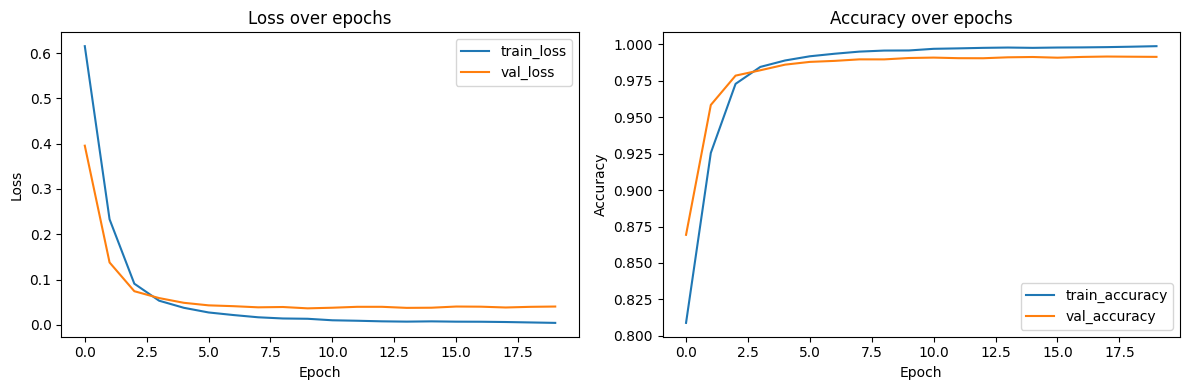

Step 8: Evaluating on test set with built-in metrics...
276/276 [==============================] - 1s 5ms/step - loss: 0.0372 - accuracy: 0.9919

Test Loss: 0.0372
Test Accuracy: 0.9919
Finished built-in evaluation!
Step 9: Building inference models...
Inference models built successfully!
Inference function defined!
Step 11: Running custom evaluations (F1)...
Calling evaluate_exact_match_f1...
Evaluating Exact Match F1 with tqdm progress bar...


100%|███████████████████████████████████████████████████████████████████████████████| 8824/8824 [40:24<00:00,  3.64it/s]


Exact-match F1: 0.9279552909731502
Exact F1 result: 0.9280
Calling evaluate_char_level_f1...
Evaluating Character-Level F1 with tqdm progress bar...


100%|███████████████████████████████████████████████████████████████████████████████| 8824/8824 [40:31<00:00,  3.63it/s]


Character-level F1 (micro): 0.9124765666845206
Character-level F1 (micro): 0.9125
Step 12: Performing a sample inference...
Word: abiliana, Predicted root: bily
Step 13: Saving model to seq2seq_stemmer.h5...


/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved successfully!

All done!


In [1]:
import os
# Turn off most TF logging before loading TF
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import sqlite3
import numpy as np
from tqdm import tqdm  # For progress bars in evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt  # For plotting training curves

import tensorflow as tf
tf.get_logger().setLevel('ERROR')  # Extra quiet mode

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

# -------------------------------------------------------------------
# 1. CONNECT TO DATABASE AND RETRIEVE DATA
# -------------------------------------------------------------------
print("Step 1: Connecting to DB and retrieving data...")
conn_dict = sqlite3.connect('dictionary.db')
cursor_dict = conn_dict.cursor()

cursor_dict.execute("""
    SELECT d.derivative, r.root 
    FROM derivatives d
    JOIN root_words r ON d.root_id = r.id
""")
data = cursor_dict.fetchall()
conn_dict.close()

inflected_words, root_words = zip(*data)
inflected_words = list(inflected_words)
root_words = list(root_words)

print("Number of total pairs:", len(inflected_words))

# -------------------------------------------------------------------
# 2. BUILD CHARACTER VOCAB
# -------------------------------------------------------------------
print("Step 2: Building character vocabulary...")
all_chars = set()
for word in inflected_words + root_words:
    for char in word:
        all_chars.add(char)

# Add special tokens for start/end/pad
all_chars.add('<start>')
all_chars.add('<end>')
all_chars.add('<pad>')  # optional if doing character-level F1

char_to_int = {char: i for i, char in enumerate(sorted(all_chars))}
int_to_char = {i: char for char, i in char_to_int.items()}

num_encoder_tokens = len(char_to_int)
num_decoder_tokens = len(char_to_int)

print("Vocabulary size:", num_encoder_tokens)

# -------------------------------------------------------------------
# 3. HELPER FUNCTION TO VECTORIZE WORDS
# -------------------------------------------------------------------
def vectorize_data(words, char_to_int, max_length, add_start_end=False):
    """
    Convert each word into a list of integer IDs, optionally
    adding <start> and <end> tokens, then pad.
    """
    sequences = []
    for word in words:
        seq = []
        if add_start_end:
            seq.append(char_to_int['<start>'])
        for char in word:
            seq.append(char_to_int[char])
        if add_start_end:
            seq.append(char_to_int['<end>'])
        sequences.append(seq)
    return pad_sequences(sequences, maxlen=max_length, padding='post')

# -------------------------------------------------------------------
# 4. DETERMINE MAX SEQUENCE LENGTHS
# -------------------------------------------------------------------
print("Step 4: Determining max sequence lengths...")
max_encoder_seq_length = max(len(word) for word in inflected_words) + 2
max_decoder_seq_length = max(len(word) for word in root_words) + 2

print("Max encoder length:", max_encoder_seq_length)
print("Max decoder length:", max_decoder_seq_length)

# -------------------------------------------------------------------
# 5. SPLIT RAW STRINGS -> Then Vectorize
# -------------------------------------------------------------------
print("Step 5: Splitting data into train/test and vectorizing...")

(
    inflected_words_train,
    inflected_words_test,
    root_words_train,
    root_words_test
) = train_test_split(
    inflected_words,
    root_words,
    test_size=0.2,
    random_state=42
)

encoder_input_train = vectorize_data(inflected_words_train, char_to_int, max_encoder_seq_length, add_start_end=True)
decoder_input_train = vectorize_data(root_words_train, char_to_int, max_decoder_seq_length, add_start_end=True)

encoder_input_test = vectorize_data(inflected_words_test, char_to_int, max_encoder_seq_length, add_start_end=True)
decoder_input_test = vectorize_data(root_words_test, char_to_int, max_decoder_seq_length, add_start_end=True)

# The decoder target is just the same as input but shifted by 1
decoder_target_train = np.zeros_like(decoder_input_train)
decoder_target_train[:, :-1] = decoder_input_train[:, 1:]
decoder_target_train = to_categorical(decoder_target_train, num_classes=num_decoder_tokens)

decoder_target_test = np.zeros_like(decoder_input_test)
decoder_target_test[:, :-1] = decoder_input_test[:, 1:]
decoder_target_test = to_categorical(decoder_target_test, num_classes=num_decoder_tokens)

print("Training samples:", encoder_input_train.shape[0])
print("Testing samples:", encoder_input_test.shape[0])

# -------------------------------------------------------------------
# 6. BUILD THE SEQ2SEQ MODEL
# -------------------------------------------------------------------
print("Step 6: Building Seq2Seq model...")
latent_dim = 512

# -- Encoder --
encoder_inputs = Input(shape=(None,), name='encoder_input')
encoder_embedding = Embedding(input_dim=num_encoder_tokens, output_dim=latent_dim, name='encoder_embedding')
embedded_encoder = encoder_embedding(encoder_inputs)

encoder_lstm = LSTM(latent_dim, return_state=True, name='encoder_lstm')
_, state_h, state_c = encoder_lstm(embedded_encoder)
encoder_states = [state_h, state_c]

# -- Decoder --
decoder_inputs = Input(shape=(None,), name='decoder_input')
decoder_embedding_layer = Embedding(input_dim=num_decoder_tokens, output_dim=latent_dim, name='decoder_embedding')
embedded_decoder = decoder_embedding_layer(decoder_inputs)

decoder_lstm_layer = LSTM(latent_dim, return_sequences=True, return_state=True, name='decoder_lstm')
decoder_outputs, _, _ = decoder_lstm_layer(embedded_decoder, initial_state=encoder_states)

decoder_dense = Dense(num_decoder_tokens, activation='softmax', name='decoder_dense')
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# -------------------------------------------------------------------
# 7. TRAIN
# -------------------------------------------------------------------
print("Step 7: Training model...")
batch_size = 64
epochs = 20

history = model.fit(
    [encoder_input_train, decoder_input_train],
    decoder_target_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2
)

print("Finished training!")

# 7.1 Plot training & validation loss + accuracy
print("Plotting training curves...")
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# -------------------------------------------------------------------
# 8. EVALUATE ON TEST SET DIRECTLY
# -------------------------------------------------------------------
print("Step 8: Evaluating on test set with built-in metrics...")
test_loss, test_accuracy = model.evaluate([encoder_input_test, decoder_input_test], decoder_target_test)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print("Finished built-in evaluation!")

# -------------------------------------------------------------------
# 9. BUILD INFERENCE MODELS
# -------------------------------------------------------------------
print("Step 9: Building inference models...")
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,), name='decoder_state_h')
decoder_state_input_c = Input(shape=(latent_dim,), name='decoder_state_c')
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_inference_embedded = decoder_embedding_layer(decoder_inputs)
decoder_outputs2, state_h2, state_c2 = decoder_lstm_layer(
    decoder_inference_embedded,
    initial_state=decoder_states_inputs
)
decoder_outputs2 = decoder_dense(decoder_outputs2)
decoder_states2 = [state_h2, state_c2]

decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2
)

print("Inference models built successfully!")

# -------------------------------------------------------------------
# 10. INFERENCE FUNCTION
# -------------------------------------------------------------------
def stem_word(input_word):
    """
    Given a single derived form, produce the predicted root
    using the trained encoder/decoder models.
    """
    # Vectorize with <start> and <end> (padded)
    input_seq = vectorize_data([input_word], char_to_int, max_encoder_seq_length, add_start_end=True)
    # Encode
    states_value = encoder_model.predict(input_seq, verbose=0)

    # Generate empty target sequence with just <start>
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = char_to_int['<start>']

    decoded_sentence = ""
    stop_condition = False

    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value, verbose=0)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = int_to_char[sampled_token_index]
        decoded_sentence += sampled_char

        # Check end token or length
        if (sampled_char == '<end>' or len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update for next iteration
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index
        states_value = [h, c]

    # Strip the <end> token
    decoded_sentence = decoded_sentence.replace('<end>', '')
    return decoded_sentence

print("Inference function defined!")

# -------------------------------------------------------------------
# 11. CUSTOM EVALUATION
# -------------------------------------------------------------------
print("Step 11: Running custom evaluations (F1)...")

# 11.1 Exact-match F1
def evaluate_exact_match_f1(inflected_test, root_test):
    """
    For each pair in the test set, check if the predicted root == true root.
    We then treat correct predictions as '1' and incorrect as '0', so
    we can compute the F1 on this binary classification.
    """
    print("Evaluating Exact Match F1 with tqdm progress bar...")
    y_true = []
    y_pred = []
    for inf_word, true_root in tqdm(zip(inflected_test, root_test), total=len(inflected_test)):
        pred_root = stem_word(inf_word)
        y_pred.append(1 if pred_root == true_root else 0)
        y_true.append(1)  # There's always exactly one correct root => label=1
    f1 = f1_score(y_true, y_pred)
    print("Exact-match F1:", f1)
    return f1

# 11.2 Character-level F1
def evaluate_char_level_f1(inflected_test, root_test):
    """
    We compare the predicted vs. true root characters.
    We flatten all characters of all words and compute micro-average F1.
    """
    print("Evaluating Character-Level F1 with tqdm progress bar...")
    all_y_true = []
    all_y_pred = []
    for inf_word, true_root in tqdm(zip(inflected_test, root_test), total=len(inflected_test)):
        pred_root = stem_word(inf_word)
        pred_chars = list(pred_root)
        true_chars = list(true_root)

        # Pad to same length
        max_len = max(len(pred_chars), len(true_chars))
        pred_chars += ['<pad>'] * (max_len - len(pred_chars))
        true_chars += ['<pad>'] * (max_len - len(true_chars))

        pred_ids = [char_to_int.get(ch, char_to_int['<end>']) for ch in pred_chars]
        true_ids = [char_to_int.get(ch, char_to_int['<end>']) for ch in true_chars]

        all_y_pred.extend(pred_ids)
        all_y_true.extend(true_ids)

    f1 = f1_score(all_y_true, all_y_pred, average='micro')
    print("Character-level F1 (micro):", f1)
    return f1

# Actually run the custom evaluations
print("Calling evaluate_exact_match_f1...")
exact_f1 = evaluate_exact_match_f1(inflected_words_test, root_words_test)
print(f"Exact F1 result: {exact_f1:.4f}")

print("Calling evaluate_char_level_f1...")
char_f1 = evaluate_char_level_f1(inflected_words_test, root_words_test)
print(f"Character-level F1 (micro): {char_f1:.4f}")

# -------------------------------------------------------------------
# 12. EXAMPLE USE
# -------------------------------------------------------------------
print("Step 12: Performing a sample inference...")
sample_word = "abiliana"
predicted = stem_word(sample_word)
print(f"Word: {sample_word}, Predicted root: {predicted}")

# -------------------------------------------------------------------
# 13. SAVE MODEL FOR HUGGING FACE / GITHUB
# -------------------------------------------------------------------
print("Step 13: Saving model to seq2seq_stemmer.h5...")
model.save("seq2seq_stemmer.h5")
print("Model saved successfully!")

print("\nAll done!")  # Final marker that code truly finished
